# Ecuador Macro Deep Dive — Visual Analysis

Charts exploring Ecuador's macroeconomic trajectory, with a focus on the effects of dollarisation (adopted in 2000).

Data sources: **IMF DataMapper**, **World Bank WDI**, and **FRED**.

Built by [@AscendedYield](https://x.com/AscendedYield)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams.update({
    'figure.figsize': (12, 5),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11,
})

DATA = 'ecuador_data'

# Load IMF wide-format data
imf = pd.read_csv(f'{DATA}/imf/ecuador_imf_all_indicators.csv')
imf = imf.set_index('Year').sort_index()

# Load World Bank wide-format data
wb = pd.read_csv(f'{DATA}/worldbank/ecuador_wb_all_indicators.csv')
wb = wb.set_index('Year').sort_index()

# Helper to load a FRED series
def load_fred(filename):
    df = pd.read_csv(f'{DATA}/fred/{filename}', parse_dates=['date'])
    df = df.set_index('date').sort_index()
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    return df

DOLLAR_YEAR = 2000  # Ecuador adopted the USD

def add_dollarisation_line(ax, label=True):
    """Add a vertical line marking dollarisation."""
    ax.axvline(DOLLAR_YEAR, color='green', linestyle='--', alpha=0.6, linewidth=1)
    if label:
        ax.text(DOLLAR_YEAR + 0.3, ax.get_ylim()[1] * 0.95, 'Dollarisation',
                color='green', fontsize=9, va='top')

print('Data loaded.')

Data loaded.


---
## 1. GDP Trends

Nominal GDP (current US$) and real GDP growth rate — showing Ecuador's expansion path before and after dollarisation.

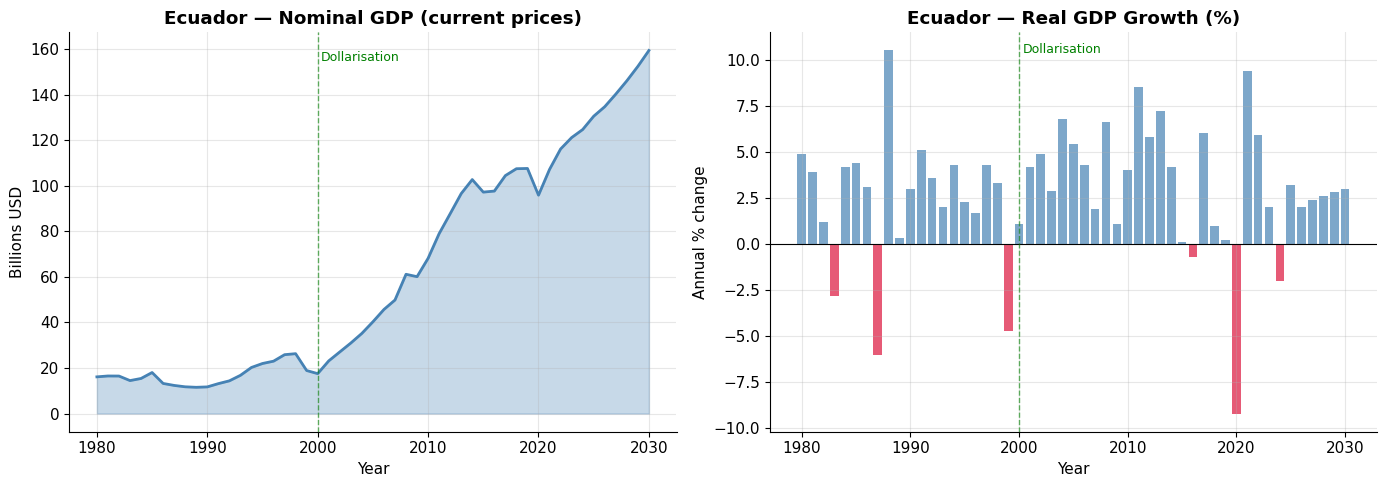

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Nominal GDP ---
gdp_col = 'GDP, current prices [NGDPD]'
gdp = imf[gdp_col].dropna()

ax1.fill_between(gdp.index, gdp.values, alpha=0.3, color='steelblue')
ax1.plot(gdp.index, gdp.values, color='steelblue', linewidth=2)
ax1.set_title('Ecuador — Nominal GDP (current prices)', fontweight='bold')
ax1.set_ylabel('Billions USD')
ax1.set_xlabel('Year')
add_dollarisation_line(ax1)

# --- Real GDP growth ---
growth_col = 'Real GDP growth [NGDP_RPCH]'
growth = imf[growth_col].dropna()

colors = ['crimson' if v < 0 else 'steelblue' for v in growth.values]
ax2.bar(growth.index, growth.values, color=colors, alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_title('Ecuador — Real GDP Growth (%)', fontweight='bold')
ax2.set_ylabel('Annual % change')
ax2.set_xlabel('Year')
add_dollarisation_line(ax2)

plt.tight_layout()
plt.savefig('gdp_trends.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 2. Debt-to-GDP

Government gross debt as a share of GDP — the key fiscal sustainability metric for a dollarised economy with no central bank lender of last resort.

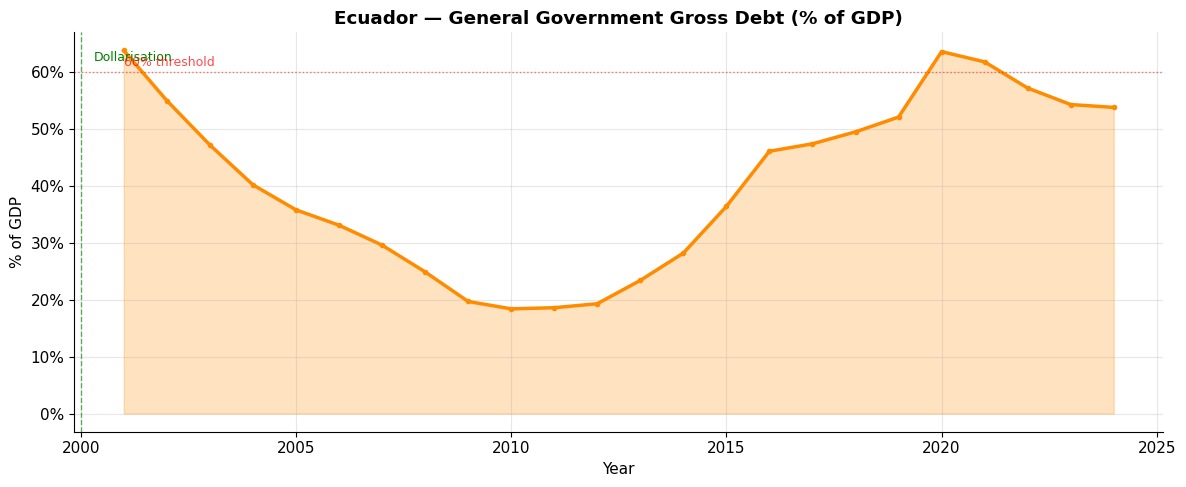

In [3]:
fig, ax = plt.subplots(figsize=(12, 5))

debt_col = 'General government gross debt [GGXWDG_NGDP]'
debt = imf[debt_col].dropna()

ax.fill_between(debt.index, debt.values, alpha=0.25, color='darkorange')
ax.plot(debt.index, debt.values, color='darkorange', linewidth=2.5, marker='o', markersize=3)
ax.set_title('Ecuador — General Government Gross Debt (% of GDP)', fontweight='bold')
ax.set_ylabel('% of GDP')
ax.set_xlabel('Year')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
add_dollarisation_line(ax)

# Highlight key thresholds
ax.axhline(60, color='red', linestyle=':', alpha=0.5, linewidth=1)
ax.text(debt.index[0], 61, '60% threshold', color='red', fontsize=9, alpha=0.7)

plt.tight_layout()
plt.savefig('debt_to_gdp.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Inflation vs US Fed Funds Rate

Since Ecuador uses the US dollar, it has no independent monetary policy. The Fed funds rate is effectively Ecuador's policy rate. This chart overlays Ecuador's inflation with the Fed's rate to show the transmission (or lack thereof).

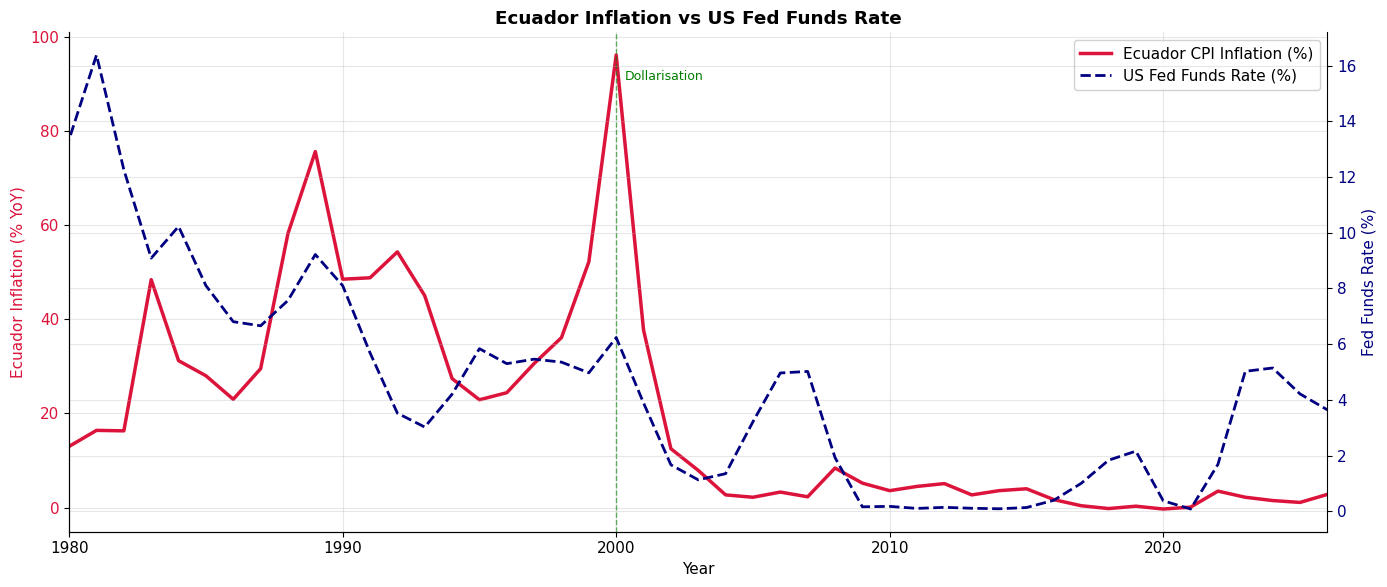

In [4]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Ecuador inflation (annual, from IMF)
infl_col = 'Inflation rate, average consumer prices [PCPIPCH]'
infl = imf[infl_col].dropna()

# Fed funds rate (monthly → annual average)
ffr = load_fred('us_fed_funds_rate.csv')
ffr_annual = ffr.resample('YE').mean()
ffr_annual.index = ffr_annual.index.year

# Plot Ecuador inflation
color_infl = 'crimson'
ax1.plot(infl.index, infl.values, color=color_infl, linewidth=2.5, label='Ecuador CPI Inflation (%)')
ax1.set_ylabel('Ecuador Inflation (% YoY)', color=color_infl)
ax1.tick_params(axis='y', labelcolor=color_infl)
ax1.set_xlabel('Year')

# Plot Fed funds rate on secondary axis
ax2 = ax1.twinx()
color_ffr = 'navy'
ax2.plot(ffr_annual.index, ffr_annual['value'].values, color=color_ffr,
         linewidth=2, linestyle='--', label='US Fed Funds Rate (%)')
ax2.set_ylabel('Fed Funds Rate (%)', color=color_ffr)
ax2.tick_params(axis='y', labelcolor=color_ffr)
ax2.spines['right'].set_visible(True)

# Shared x-axis range
x_min = max(infl.index.min(), ffr_annual.index.min())
x_max = min(infl.index.max(), ffr_annual.index.max())
ax1.set_xlim(x_min, x_max)

# Dollarisation line
ax1.axvline(DOLLAR_YEAR, color='green', linestyle='--', alpha=0.6, linewidth=1)
ax1.text(DOLLAR_YEAR + 0.3, ax1.get_ylim()[1] * 0.92, 'Dollarisation',
         color='green', fontsize=9, va='top')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', framealpha=0.9)

ax1.set_title('Ecuador Inflation vs US Fed Funds Rate', fontweight='bold')
plt.tight_layout()
plt.savefig('inflation_vs_fed_rate.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Oil Price Correlation

Oil is Ecuador's top export. This chart shows how GDP growth tracks crude oil prices — a key vulnerability for the economy.

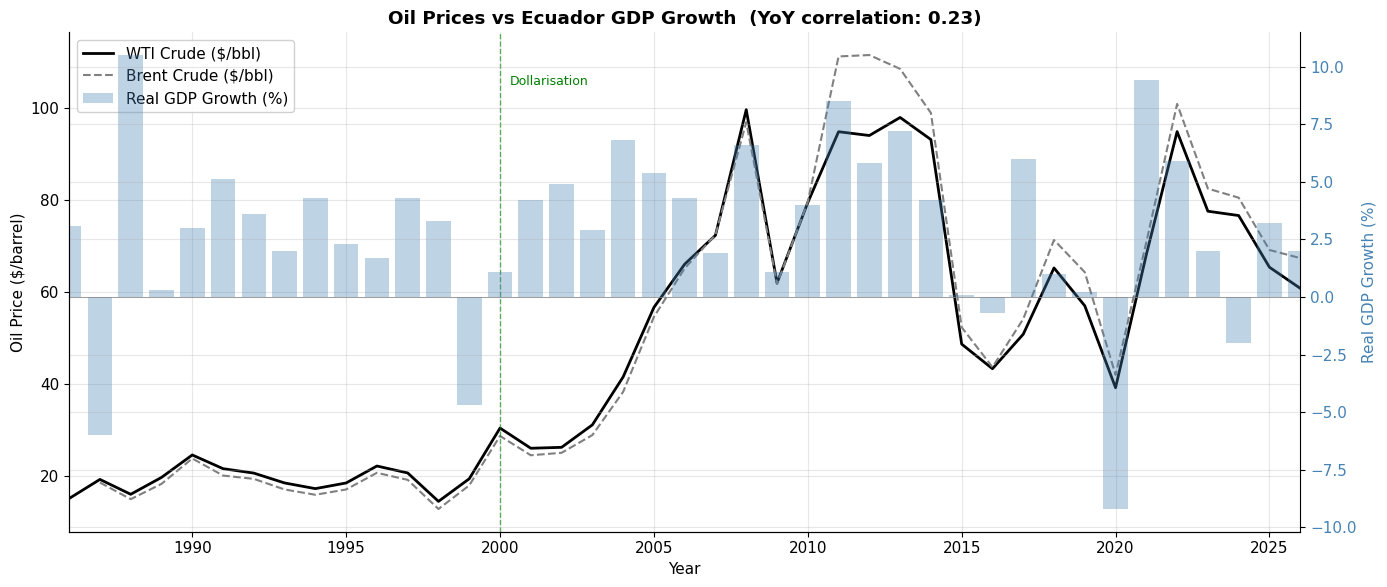

In [5]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# WTI crude oil (daily → annual average)
wti = load_fred('wti_crude_oil_price.csv')
wti_annual = wti.resample('YE').mean()
wti_annual.index = wti_annual.index.year

# Brent crude oil (daily → annual average)
brent = load_fred('brent_crude_oil_price.csv')
brent_annual = brent.resample('YE').mean()
brent_annual.index = brent_annual.index.year

# GDP growth from IMF
growth_col = 'Real GDP growth [NGDP_RPCH]'
growth = imf[growth_col].dropna()

# Plot oil prices
color_oil = 'black'
ax1.plot(wti_annual.index, wti_annual['value'], color=color_oil, linewidth=2,
         label='WTI Crude ($/bbl)')
ax1.plot(brent_annual.index, brent_annual['value'], color='gray', linewidth=1.5,
         linestyle='--', label='Brent Crude ($/bbl)')
ax1.set_ylabel('Oil Price ($/barrel)', color=color_oil)
ax1.tick_params(axis='y', labelcolor=color_oil)
ax1.set_xlabel('Year')

# GDP growth on secondary axis
ax2 = ax1.twinx()
color_gdp = 'steelblue'
ax2.bar(growth.index, growth.values, alpha=0.35, color=color_gdp, label='Real GDP Growth (%)')
ax2.set_ylabel('Real GDP Growth (%)', color=color_gdp)
ax2.tick_params(axis='y', labelcolor=color_gdp)
ax2.spines['right'].set_visible(True)
ax2.axhline(0, color='gray', linewidth=0.5)

# Shared range (oil data starts later)
x_min = max(growth.index.min(), wti_annual.index.min())
x_max = min(growth.index.max(), wti_annual.index.max())
ax1.set_xlim(x_min, x_max)

# Dollarisation line
ax1.axvline(DOLLAR_YEAR, color='green', linestyle='--', alpha=0.6, linewidth=1)
ax1.text(DOLLAR_YEAR + 0.3, ax1.get_ylim()[1] * 0.92, 'Dollarisation',
         color='green', fontsize=9, va='top')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', framealpha=0.9)

# Correlation stat
merged = pd.DataFrame({'oil': wti_annual['value'], 'gdp': growth}).dropna()
corr = merged['oil'].pct_change().corr(merged['gdp'])
ax1.set_title(f'Oil Prices vs Ecuador GDP Growth  (YoY correlation: {corr:.2f})',
              fontweight='bold')

plt.tight_layout()
plt.savefig('oil_price_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Summary Dashboard

All four key metrics in a single view.

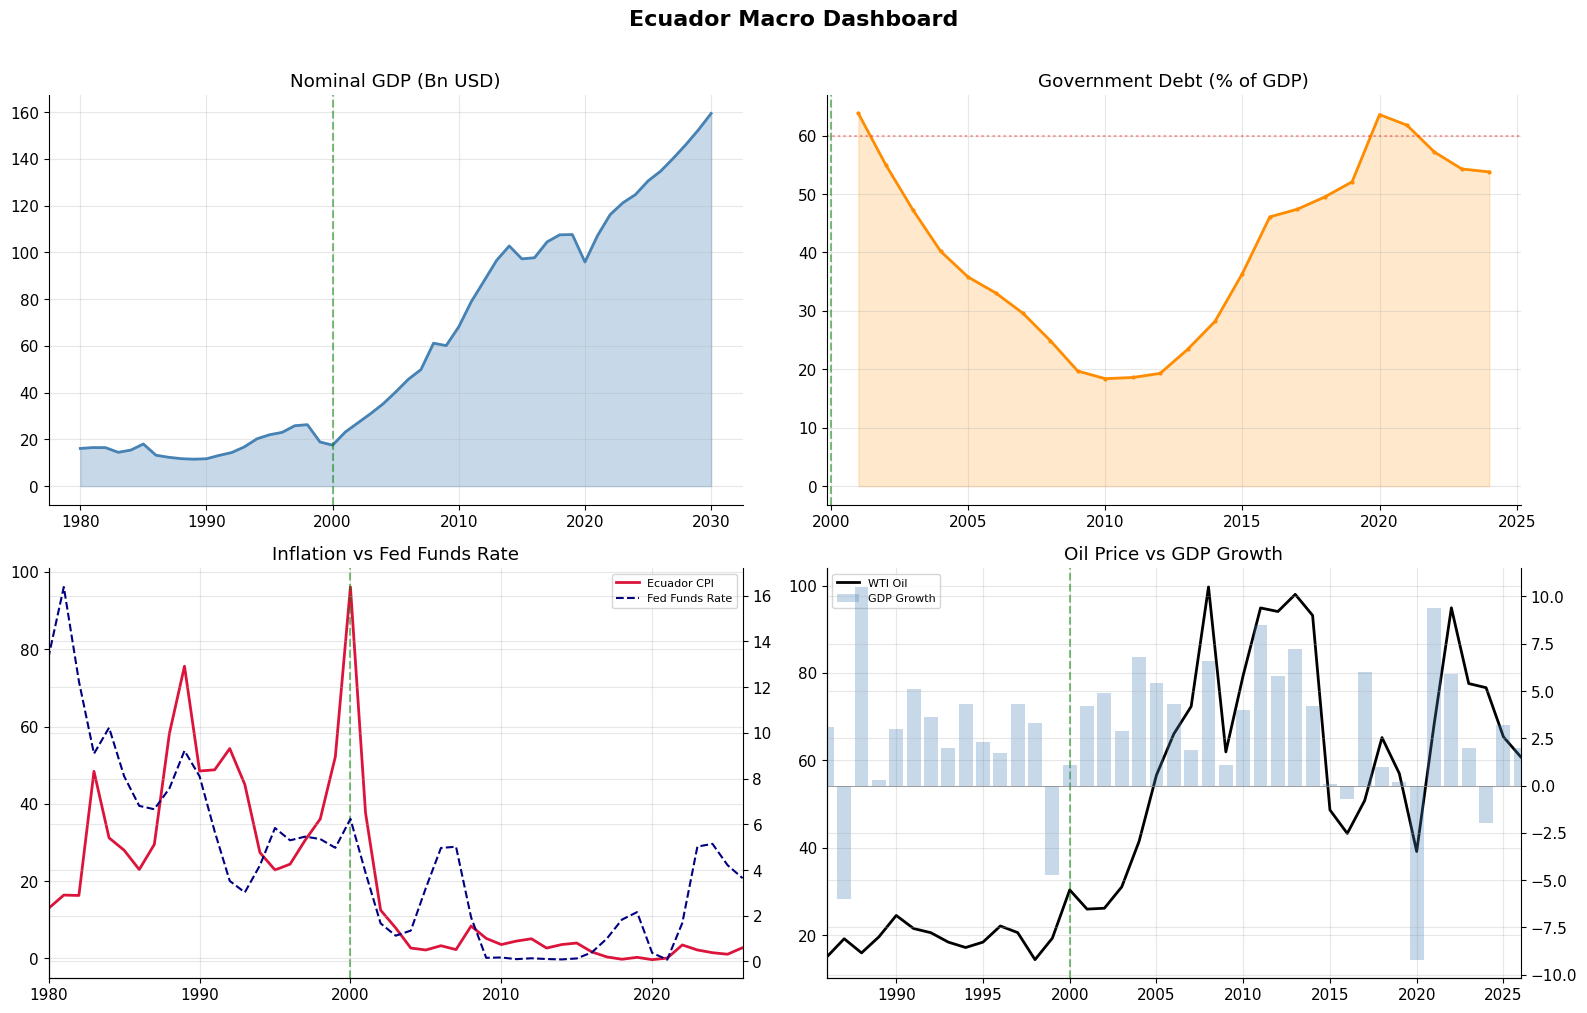

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Ecuador Macro Dashboard', fontsize=16, fontweight='bold', y=1.01)

# 1. Nominal GDP
ax = axes[0, 0]
gdp = imf['GDP, current prices [NGDPD]'].dropna()
ax.fill_between(gdp.index, gdp.values, alpha=0.3, color='steelblue')
ax.plot(gdp.index, gdp.values, color='steelblue', linewidth=2)
ax.set_title('Nominal GDP (Bn USD)')
ax.axvline(DOLLAR_YEAR, color='green', linestyle='--', alpha=0.5)

# 2. Debt-to-GDP
ax = axes[0, 1]
debt = imf['General government gross debt [GGXWDG_NGDP]'].dropna()
ax.plot(debt.index, debt.values, color='darkorange', linewidth=2, marker='o', markersize=2)
ax.fill_between(debt.index, debt.values, alpha=0.2, color='darkorange')
ax.set_title('Government Debt (% of GDP)')
ax.axvline(DOLLAR_YEAR, color='green', linestyle='--', alpha=0.5)
ax.axhline(60, color='red', linestyle=':', alpha=0.4)

# 3. Inflation vs Fed Rate
ax = axes[1, 0]
infl = imf['Inflation rate, average consumer prices [PCPIPCH]'].dropna()
ax.plot(infl.index, infl.values, color='crimson', linewidth=2, label='Ecuador CPI')
ax_twin = ax.twinx()
ax_twin.plot(ffr_annual.index, ffr_annual['value'], color='navy', linewidth=1.5,
             linestyle='--', label='Fed Funds Rate')
ax_twin.spines['right'].set_visible(True)
ax.set_title('Inflation vs Fed Funds Rate')
ax.axvline(DOLLAR_YEAR, color='green', linestyle='--', alpha=0.5)
x_min = max(infl.index.min(), ffr_annual.index.min())
x_max = min(infl.index.max(), ffr_annual.index.max())
ax.set_xlim(x_min, x_max)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)

# 4. Oil vs GDP Growth
ax = axes[1, 1]
growth = imf['Real GDP growth [NGDP_RPCH]'].dropna()
ax.plot(wti_annual.index, wti_annual['value'], color='black', linewidth=2, label='WTI Oil')
ax_twin2 = ax.twinx()
ax_twin2.bar(growth.index, growth.values, alpha=0.3, color='steelblue', label='GDP Growth')
ax_twin2.spines['right'].set_visible(True)
ax_twin2.axhline(0, color='gray', linewidth=0.5)
ax.set_title('Oil Price vs GDP Growth')
ax.axvline(DOLLAR_YEAR, color='green', linestyle='--', alpha=0.5)
x_min = max(growth.index.min(), wti_annual.index.min())
x_max = min(growth.index.max(), wti_annual.index.max())
ax.set_xlim(x_min, x_max)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_twin2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)

plt.tight_layout()
plt.savefig('ecuador_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()